# Loading and Viewing BubbleML

In [29]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

### Create an h5py file
In this case, we are using the simulation run with a wall temperature of 100 degrees Celsius.
The simulation file includes a list of keys:
  1. dfun is the distance function from the bubbble interface
  2. pressure is the pressure gradient
  3. temperature is the temperature map
  4. velx is the velocity in the x direction
  5. vely is the velocity in the y direction
  6. x and y are coordinate grids
  7. int/real-runtime-params are metadata associated with the simulation run.
     This includes things like the Reynold's number, simulation dimensions, etc.

In [30]:
twall_100 = h5py.File('Twall-100.hdf5', 'r')

print(twall_100.keys())

<KeysViewHDF5 ['dfun', 'int-runtime-params', 'pressure', 'real-runtime-params', 'temperature', 'velx', 'vely', 'x', 'y']>


### Tensor sizes
Each tensor is laid out [T x X x Y] (time, x-direction, y-direction). In this case, there are 200 time steps and the domain resolution is 48x48

In [43]:
[time_res, x_res, y_res] = twall_100['temperature'][:].shape

print(f'# Timesteps: {time_res}')
print(f'Domain resolution: {x_res} x {y_res}')

# Timesteps: 201
Domain resolution: 48 x 48


### Visualizing the data
The data can be easily loaded into numpy (or torch, tensorflow, etc) arrays and visualized with matplotlib.

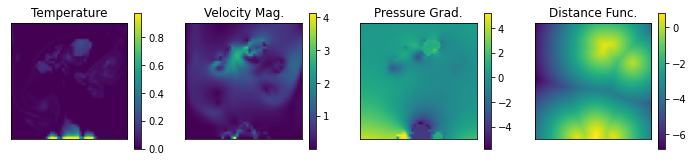

In [63]:
temp = twall_100['temperature'][:]
velx = twall_100['velx'][:]
vely = twall_100['vely'][:]
pres = twall_100['pressure'][:]
dfun = twall_100['dfun'][:]

# compute the velocity magnitude
mag = np.sqrt(velx**2 + vely**2)

# plot the 50-th timestep for each variable
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

data = {
    'Temperature': temp[50],
    'Velocity Mag.': mag[50],
    'Pressure Grad.': pres[50],
    'Distance Func.': dfun[50]
}

for idx, (key, im) in enumerate(data.items()):
    im = ax[idx].imshow(np.flipud(im))
    fig.colorbar(im, ax=ax[idx], shrink=0.5)
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

### Using dfun
dfun is a *signed distance function* to the liquid-vapor interfaces. 
dfun > 0 means the point is in vapor, dfun < 0 means the point is in liquid. It is also a convenient way to identify the bubble interfaces.

In [64]:
@nb.njit
def get_interface_mask(dgrid):
    r""" heavy-side function to determine the bubble interfaces
    """
    interface = np.zeros(dgrid.shape).astype(np.bool_)
    [rows, cols] = dgrid.shape
    for i in range(rows):
        for j in range(cols):
            adj = ((i < rows - 1 and dgrid[i][j] * dgrid[i+1, j  ] <= 0) or
                   (i > 0 and dgrid[i][j] * dgrid[i-1, j  ] <= 0) or
                   (j < cols - 1 and dgrid[i][j] * dgrid[i,   j+1] <= 0) or
                   (j > 0 and dgrid[i][j] * dgrid[i,   j-1] <= 0))
            interface[i][j] = adj
    return interface

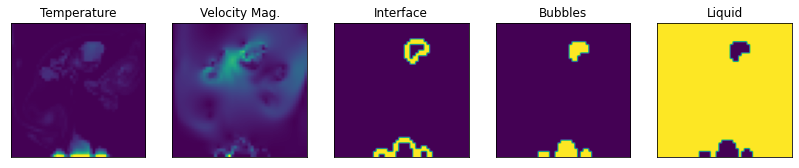

In [65]:
fig, ax = plt.subplots(1, 5, figsize=(14, 5))

bubbles = dfun[50] >= 0
liquid = dfun[50] < 0
interface = get_interface_mask(dfun[50])

data = {
    'Temperature': temp[50],
    'Velocity Mag.': mag[50],
    'Interface': interface,
    'Bubbles': bubbles,
    'Liquid': liquid
}

for idx, (key, im) in enumerate(data.items()):
    ax[idx].imshow(np.flipud(im))
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])